In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [2]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [36]:
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11) 
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    x, y, theta = curr_pose
    L = 0.9
    x += v*np.cos(theta)
    y += v*np.sin(theta)
    theta += (v*np.tan(delta))/L
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
   
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.11) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expected:
    (1.0, 0.0, 1.11) 
Got:
    (1.0, 0.0, 1.111111111111111)


In [37]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = np.ones(steps)
all_delta = np.zeros(steps)
for v,delta in zip(all_v,all_delta):
   #store pose
   straight_trajectory.append(pose) 
   #compute new pose
   pose = bicycle_model(pose, v, delta)
straight_trajectory = np.array(straight_trajectory)

In [38]:
straight_trajectory

array([[0.00000000e+00, 0.00000000e+00, 1.57079633e+00],
       [6.12323400e-17, 1.00000000e+00, 1.57079633e+00],
       [1.22464680e-16, 2.00000000e+00, 1.57079633e+00],
       [1.83697020e-16, 3.00000000e+00, 1.57079633e+00],
       [2.44929360e-16, 4.00000000e+00, 1.57079633e+00],
       [3.06161700e-16, 5.00000000e+00, 1.57079633e+00],
       [3.67394040e-16, 6.00000000e+00, 1.57079633e+00],
       [4.28626380e-16, 7.00000000e+00, 1.57079633e+00],
       [4.89858720e-16, 8.00000000e+00, 1.57079633e+00],
       [5.51091060e-16, 9.00000000e+00, 1.57079633e+00]])

In [65]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v = np.ones(steps*100)
all_delta = np.ones(steps*100)
for v,delta in zip(all_v , all_delta):
   #store pose
   circle_trajectory.append(pose)
   #compute new pose
   pose = bicycle_model(pose,v,delta,0.01)
circle_trajectory = np.array(circle_trajectory)


In [40]:
circle_trajectory

array([[ 0.00000000e+00,  0.00000000e+00,  1.57079633e+00],
       [ 6.12323400e-17,  1.00000000e+00, -2.98193595e+00],
       [-9.87281919e-01,  8.41020717e-01, -1.25148293e+00],
       ...,
       [-1.04560177e+00,  7.17756053e-01, -1.04349484e+00],
       [-5.42398555e-01, -1.46412060e-01,  6.86958192e-01],
       [ 2.30780113e-01,  4.87776198e-01,  2.41741122e+00]])

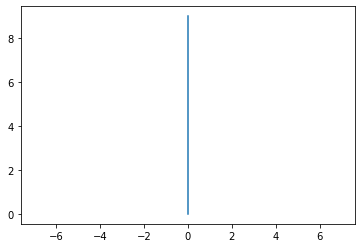

In [41]:
### Plotting straight trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])

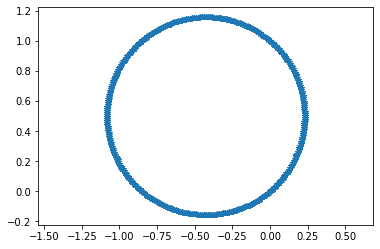

In [70]:
### Plotting circle trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1],'*')

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [55]:
vc = 1 # m/s
delta_c = np.pi/12 # rad/s
L = 0.9 #m

#calculate time taken to finish a quarter turn (pi/4)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int(np.pi/2/(vc*np.tan(delta_c)/L)) 

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/vc) , int(5/vc) , int(8/vc)

all_delta = [0]*t_straight1 + [delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = vc*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [56]:
def get_open_loop_commands(route, vc = 1, delta = np.pi/12):
    L = 0.9
    all_delta = []
    wc = vc*np.tan(delta)/L
    omegas = {'straight':0, 'left':wc, 'right':-wc}
    for manoeuvre, command in route:
      t_cmd = np.ceil(command/vc).astype('int') if manoeuvre == 'straight' else np.ceil(np.deg2rad(command)/wc).astype('int')
      all_delta += [omegas[manoeuvre]]*t_cmd
    all_v = vc*np.ones_like(all_delta)
    #for i in all_delta:
      #all_v[i] = vc_fast if all_w[i] == 0 else vc_slow
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [57]:
all_v , all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

In [61]:
robot_trajectory = []
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]) 
pose = np.array([0, 0, np.pi/2])
for v, delta in zip(all_v, all_delta):
    #store pose
    
    #instruction to take v, w and compute new pose    
    pose = bicycle_model(pose,v,delta)
    robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

In [62]:
robot_trajectory

array([[ 6.12323400e-17,  1.00000000e+00,  1.57079633e+00],
       [ 1.22464680e-16,  2.00000000e+00,  1.57079633e+00],
       [ 1.83697020e-16,  3.00000000e+00,  1.57079633e+00],
       [ 2.44929360e-16,  4.00000000e+00,  1.57079633e+00],
       [ 3.06161700e-16,  5.00000000e+00,  1.57079633e+00],
       [ 3.67394040e-16,  6.00000000e+00,  1.22986157e+00],
       [ 3.34368197e-01,  6.94244252e+00,  8.88926805e-01],
       [ 9.64613810e-01,  7.71883834e+00,  5.47992044e-01],
       [ 1.81818615e+00,  8.23981269e+00,  2.07057283e-01],
       [ 2.79682626e+00,  8.44539362e+00, -1.33877478e-01],
       [ 3.78787805e+00,  8.31191570e+00, -4.74812239e-01],
       [ 4.67725663e+00,  7.85474424e+00, -4.74812239e-01],
       [ 5.56663520e+00,  7.39757277e+00, -4.74812239e-01],
       [ 6.45601378e+00,  6.94040131e+00, -4.74812239e-01],
       [ 7.34539236e+00,  6.48322984e+00, -4.74812239e-01],
       [ 8.23477093e+00,  6.02605838e+00, -4.74812239e-01],
       [ 9.12414951e+00,  5.56888691e+00

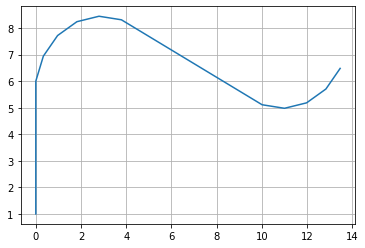

In [63]:
# plot robot trajectory
plt.figure()
plt.grid()
#plt.plot( )

#show first and last robot positions with + markers
xi,yi, thetai = robot_trajectory[0]
xf,yf, thetaf = robot_trajectory[-1]
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1])
# example: plt.plot(0, 0, 'r+', ms=10)



### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [67]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [68]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


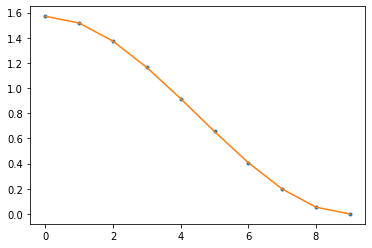

In [69]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to West)

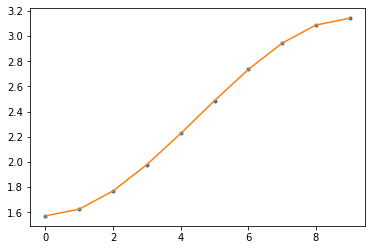

In [71]:
plt.figure()
plt.plot(poly_turn(np.pi/2, np.pi),'.')
plt.plot(poly_turn(np.pi/2, np.pi))

How does $\theta$ change when we had constant $\delta$? Plot it

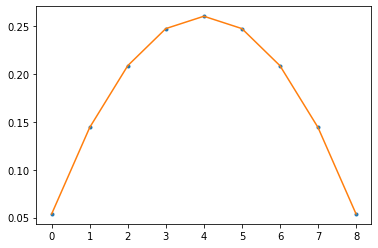

In [72]:
del_theta = np.diff(poly_turn(np.pi/2, np.pi,10))
plt.plot(del_theta,'.')
plt.plot(del_theta)

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?